In [1]:
from IPython.display import clear_output

#!pip install datasets
!pip install evaluate
#!pip install wandb -qU

import datasets
import random
import numpy as np
import torch
import torch.nn as nn
import spacy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.metrics import bleu_score
import torch.optim as optim
import tqdm
import wandb
import os
import json
import evaluate
wandb.login()

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

clear_output(wait=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


2024-08-02 17:13:26.911406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 17:13:26.911509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 17:13:27.047606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 73.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [2]:
seed = 777

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
data = datasets.load_dataset("bentrevett/multi30k")
train_data, valid_data, test_data = (data['train'],data['validation'],data['test'])

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
def show_examples(data, number_of_examples = 5,by=['en','de']):
    space = 80
    print(f'{"english": ^{space}} <-> {"german": ^{space}}')
    for i in range(number_of_examples):
        print(f'{data[by[0]][i] : <{space}} <-> {data[by[1]][i]: >{space}}')
show_examples(train_data)

                                    english                                      <->                                      german                                     
Two young, White males are outside near many bushes.                             <->                Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Several men in hard hats are operating a giant pulley system.                    <->                  Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
A little girl climbing into a wooden playhouse.                                  <->                          Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
A man in a blue shirt is standing on a ladder cleaning a window.                 <->      Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
Two men are at the stove preparing food.                                         <->                                Zwei Männer stehen am Herd und bereiten Essen zu.


In [5]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

def tokenizer(data,en,de,max_lenght=1024,lower_case=True,start_token = '<sos>', end_token = '<eos>'):
    en_tokens = [token.text for token in en(data['en'])][:max_lenght]
    de_tokens = [token.text for token in de(data['de'])][:max_lenght]
    if lower_case:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    return {"en_tokens": [start_token] + en_tokens + [end_token], "de_tokens": [start_token] + de_tokens + [end_token]}

lower = True
sos_token = "<sos>"
eos_token = "<eos>"

kwargs = {
    "en": en_nlp,
    "de": de_nlp,
    'max_lenght':1024,
    'lower_case':lower,
    'start_token':sos_token,
    'end_token':eos_token
}

train_data = train_data.map(tokenizer, fn_kwargs=kwargs)
valid_data = valid_data.map(tokenizer, fn_kwargs=kwargs)
test_data = test_data.map(tokenizer, fn_kwargs=kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
min_freq = 2
special_tokens = ['<unk>','<pad>','<sos>','<eos>']
en_vocab = build_vocab_from_iterator(
    train_data['en_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)
de_vocab = build_vocab_from_iterator(
    train_data['de_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

en_vocab.set_default_index(en_vocab.get_stoi()["<unk>"])
de_vocab.set_default_index(de_vocab.get_stoi()["<unk>"])

In [7]:
en_vocab.get_itos()[:4] == de_vocab.get_itos()[:4],en_vocab.get_itos()[:4],de_vocab.get_itos()[:4]

(True,
 ['<unk>', '<pad>', '<sos>', '<eos>'],
 ['<unk>', '<pad>', '<sos>', '<eos>'])

In [8]:
def string_to_index(data,en_vocab,de_vocab):
    return {'en_idx':en_vocab.lookup_indices(data['en_tokens']),'de_idx':de_vocab.lookup_indices(data['de_tokens'])}

kwargs = {
    "en_vocab": en_vocab,
    "de_vocab": de_vocab,
}

train_data = train_data.map(string_to_index, fn_kwargs=kwargs)
valid_data = valid_data.map(string_to_index, fn_kwargs=kwargs)
test_data = test_data.map(string_to_index, fn_kwargs=kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
dtype = 'torch'
columns = ['en_idx','de_idx']
train_data = train_data.with_format(
    type=dtype,
    columns=columns,
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=dtype,
    columns=columns,
    output_all_columns=True
)

test_data = test_data.with_format(
    type=dtype,
    columns=columns,
    output_all_columns=True
)

In [10]:
def get_collate(pad_index):
    def collate_fn(batch):
        batch_en_ids = [data["en_idx"] for data in batch]
        batch_de_ids = [data["de_idx"] for data in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_idx": batch_en_ids,
            "de_idx": batch_de_ids,
        }
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate = get_collate(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate,
        shuffle=shuffle,
    )
    return data_loader


def get_data(batch_size,pad_idx):
    train_data_loader = get_data_loader(train_data, batch_size,pad_idx , shuffle=True)
    valid_data_loader = get_data_loader(valid_data, batch_size, pad_idx)
    test_data_loader = get_data_loader(test_data, batch_size, pad_idx)
    return train_data_loader, valid_data_loader, test_data_loader

In [33]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden

In [71]:

class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attention = nn.Linear(encoder_hidden_dim * 2 + decoder_hidden_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_output):
        sequence_length = encoder_output.shape[0]
        batch_size = encoder_output.shape[1]
        
        # Ensure hidden is (batch_size, hidden_dim_decoder)
        hidden = hidden.unsqueeze(1).repeat(1, sequence_length, 1)
        # hidden shape: (batch_size, sequence_length, hidden_dim_decoder)
        
        encoder_output = encoder_output.permute(1, 0, 2)
        # encoder_output shape: (batch_size, sequence_length, hidden_dim_encoder * 2)
        
        e = torch.tanh(self.attention(torch.cat((hidden, encoder_output), dim=2)))
        # E shape: (batch_size, sequence_length, hidden_dim_decoder)
        
        a = self.fc_out(e).squeeze(2)
        # attention shape: (batch_size, sequence_length)
        
        attention_weights = torch.softmax(a, dim=1)
        # attention_weights shape: (batch_size, sequence_length)
        
        return attention_weights


In [82]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 embedding_dim,
                 encoder_hidden_dim, 
                 decoder_hidden_dim,
                 dropout, 
                 attention):
        super().__init__()
        self.attention = attention
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU(input_size=embedding_dim + (2 * encoder_hidden_dim), 
                           hidden_size=decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear((encoder_hidden_dim*2) + decoder_hidden_dim + embedding_dim,output_dim)
        
    def forward(self, input, hidden,encoder_output):
        # input is previous generated word or <sos> in case of teaching force input is real target word from previous step
        # input shape = (batch size) - single words
        input = input.unsqueeze(0)
        # input shape = (1, batch size) - sequences of one word
        
        embedded = self.dropout(self.embedding(input))
        # embedded shape = (sequence lenght = 1, batch_size, embedding_dim)
        
        attention = self.attention(hidden,encoder_output)
        # attention shape = (batch size, sequence length)
        attention = attention.unsqueeze(1)
        # attention shape = (batch size, 1, sequence length)
        encoder_output = encoder_output.permute(1,0,2)
        #encoer_output shape = (batch size, sequence length, encoder hidden dimension)
        weighted = torch.bmm(attention,encoder_output)
        # weighted shape = (batch size, 1, encoder hidden dimension)
        weighted = weighted.permute(1,0,2)
        # weighted shape = (1, batch size, encoder hidden dimension)
        
        rnn_input = torch.cat(
            (embedded,weighted),
            dim = 2
        )
        
        

        output, hidden = self.rnn(rnn_input,
                                  hidden.unsqueeze(0)) 
        # hidden shape = (1 * n_layers, batch size,hidden_size)
        # cell shape = (1 * n_layers, batch size,hidden_size)
        #output shape = (sequence lenght = 1, batch_size,1 * hidden_size)
        output = output.squeeze(0)
        embedded = embedded.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(
            torch.cat(
            (output,embedded,weighted),
            dim = 1)
        )
        
        return prediction,hidden.squeeze(0),attention.squeeze(1)

In [76]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs



In [59]:
def train_step(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(data_loader):
        src = batch["de_idx"].to(device)
        trg = batch["en_idx"].to(device)
        # src = [source length, batch size]
        # trg = [target length, batch size]

        optimizer.zero_grad()
        # output = [sequence length = target length, batch size, output dimension = english vocabular]
        output = model(src, trg, teacher_forcing_ratio)
        
        # output dimension
        output_dim = output.shape[-1] 
        
        # reshape and drop first item which is 0
        # shape is (sequence length * batch size, output dimension = english vocabular)
        output = output[1:].view(-1, output_dim)
        # reshape and drop first item which is <SOS>
        # shape is (target length * batch size)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        epoch_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        

    return epoch_loss / len(data_loader)


def evaluate_step(model, data_loader, criterion, device):
    
    model.eval()
    epoch_loss = 0
    bleu = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_idx"].to(device)
            trg = batch["en_idx"].to(device)
            # src = [source length, batch size]
            # trg = [target length, batch size]

            optimizer.zero_grad()
            # output = [sequence length = target length, batch size, output dimension = english vocabular]
            output = model(src, trg)

            # output dimension
            output_dim = output.shape[-1] 

            # reshape and drop first item which is 0
            # shape is (sequence length * batch size, output dimension = english vocabular)
            output = output[1:].view(-1, output_dim)
            # reshape and drop first item which is <SOS>
            # shape is (target length * batch size)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(data_loader)

In [41]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        # Tokenize the input sentence
        if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        
        # Lowercase tokens if specified
        if lower:
            tokens = [token.lower() for token in tokens]
        
        # Add special tokens
        de_tokens = [sos_token] + tokens + [eos_token]
        
        # Convert tokens to indices
        ids = de_vocab.lookup_indices(de_tokens)
        
        # Convert indices to tensor and add batch dimension
        tensor = torch.LongTensor(ids).unsqueeze(1).to(device)
        
        # Initialize hidden and cell states for the encoder
        encoder_output, hidden = model.encoder(tensor)
        
        # Initialize input for the decoder
        inputs = [en_vocab[sos_token]]
        
        # Prepare output list to store translated tokens
        translated_tokens = []
        
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            # Convert current input to tensor
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            
            # Decode the input
            output, hidden, attention = model.decoder(inputs_tensor, hidden,encoder_output)
            attentions[i] = attention
            # Get the predicted token
            predicted_token  = output.argmax(1).item()
            # Append the predicted token to inputs for the next step
            inputs.append(predicted_token)
            
            # Append predicted token to the output list
            translated_tokens.append(predicted_token)
            
            # Check for end of sequence token
            if predicted_token == en_vocab[eos_token]:
                break
        
        # Convert indices to tokens
        en_tokens = en_vocab.lookup_tokens(translated_tokens)
    
    return en_tokens

def BLEU():
    translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
    ]
    
    bleu = evaluate.load("bleu")
    predictions = [" ".join(translation[1:-1]) for translation in translations]
    references = [[example["en"]] for example in test_data]

    def get_tokenizer_fn(nlp, lower):
        def tokenizer_fn(s):
            tokens = [token.text for token in nlp.tokenizer(s)]
            if lower:
                tokens = [token.lower() for token in tokens]
            return tokens

        return tokenizer_fn

    tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

    results = bleu.compute(
        predictions=predictions, references=references, tokenizer=tokenizer_fn
    )
    return results

In [105]:
name = 'B2GRU_ATTENT'
project = 'German - English [Seq2seq]'
config = {
    'input_dimension' : len(de_vocab),
    'output_dimension' : len(en_vocab),
    'encoder_emdedding_dimension':256,
    'decoder_emdedding_dimension':256,
    'hidden_dimension_encoder': 1024,
    'hidden_dimension_decoder': 1024,
    'encoder_dropout': 0.7,
    'decoder_dropout': 0.7,
    'epochs': 10,
    'clip':1.0,
    'teacher_forcing_ratio':0.7,
    'optimzer': 'ADAM',
    'batch_size': 128,
    'learning_rate': 0.001, 
}


train_data_loader, valid_data_loader, test_data_loader = get_data(config['batch_size'],en_vocab.get_stoi()["<pad>"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_dim=config['input_dimension'],
                  embedding_dim=config['encoder_emdedding_dimension'],
                  encoder_hidden_dim=config['hidden_dimension_encoder'],
                  decoder_hidden_dim=config['hidden_dimension_decoder'],
                  dropout=config['encoder_dropout']
                 )

attention = Attention(encoder_hidden_dim=config['hidden_dimension_encoder'],decoder_hidden_dim=config['hidden_dimension_decoder'])

decoder = Decoder(output_dim=config['output_dimension'],
                  embedding_dim=config['decoder_emdedding_dimension'],
                  encoder_hidden_dim=config['hidden_dimension_encoder'],
                  decoder_hidden_dim=config['hidden_dimension_decoder'],
                  attention=attention,
                  dropout=config['decoder_dropout'])

model = Seq2Seq(encoder, decoder, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 1024, bidirectional=True)
    (fc): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=3072, out_features=1024, bias=True)
      (fc_out): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(2304, 1024)
    (dropout): Dropout(p=0.7, inplace=False)
    (fc): Linear(in_features=3328, out_features=5893, bias=True)
  )
)

In [97]:
n_epochs = config['epochs']
clip = config['clip']
teacher_forcing_ratio = config['teacher_forcing_ratio']
if config['optimzer'] == 'ADAM':
    optimizer = optim.Adam(model.parameters(),lr=config['learning_rate'])
if config['optimzer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(),lr=config['learning_rate'],momentum=config['momentum'])
    
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab.get_stoi()["<pad>"])

path = f'/kaggle/working//Models/{name}/'
os.makedirs(path,exist_ok=True)

with open(f'{path}/{name}_config.json','w') as f:
    f.write(json.dumps(config))

with open(f'{path}/{name}_layers.txt','w') as f:
    f.write(str(model))
    
with wandb.init(project=project,name=name,config=config):
    for epoch in tqdm.tqdm(range(n_epochs)):
        train_loss = train_step(
          model,
          train_data_loader,
          optimizer,
          criterion,
          clip,
          teacher_forcing_ratio,
          device,
      )

        valid_loss = evaluate_step(
          model,
          valid_data_loader,
          criterion,
          device,
      )
        torch.save(model.state_dict(), f"{path}/epoch_{epoch}.pt")


        wandb.log({
                'Training loss':train_loss,
                'Validation loss':valid_loss,
              })
        
    wandb.log(BLEU())


100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]


Training loss,█▆▄▄▃▂▂▂▁▁
Validation loss,█▄▂▁▁▂▂▃▃▄
bleu,▁
brevity_penalty,▁
length_ratio,▁
reference_length,▁
translation_length,▁
Training loss,1.09828
Validation loss,4.04666
bleu,0.27544
brevity_penalty,0.94372


In [106]:
model.load_state_dict(torch.load("/kaggle/working/Models/B2GRU_ATTENT/epoch_4.pt"))

<All keys matched successfully>

In [91]:
def translate_sentence_attention(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        # Tokenize the input sentence
        if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        
        # Lowercase tokens if specified
        if lower:
            tokens = [token.lower() for token in tokens]
        
        # Add special tokens
        de_tokens = [sos_token] + tokens + [eos_token]
        
        # Convert tokens to indices
        ids = de_vocab.lookup_indices(de_tokens)
        
        # Convert indices to tensor and add batch dimension
        tensor = torch.LongTensor(ids).unsqueeze(1).to(device)
        
        # Initialize hidden and cell states for the encoder
        encoder_output, hidden = model.encoder(tensor)
        
        # Initialize input for the decoder
        inputs = [en_vocab[sos_token]]
        
        # Prepare output list to store translated tokens
        translated_tokens = []
        
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            # Convert current input to tensor
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            
            # Decode the input
            output, hidden, attention = model.decoder(inputs_tensor, hidden,encoder_output)
            attentions[i] = attention
            # Get the predicted token
            predicted_token  = output.argmax(1).item()
            # Append the predicted token to inputs for the next step
            inputs.append(predicted_token)
            
            # Append predicted token to the output list
            translated_tokens.append(predicted_token)
            
            # Check for end of sequence token
            if predicted_token == en_vocab[eos_token]:
                break
        
        # Convert indices to tokens
        en_tokens = en_vocab.lookup_tokens(translated_tokens)
    
    return de_tokens, en_tokens,attentions

In [92]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="inferno")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()

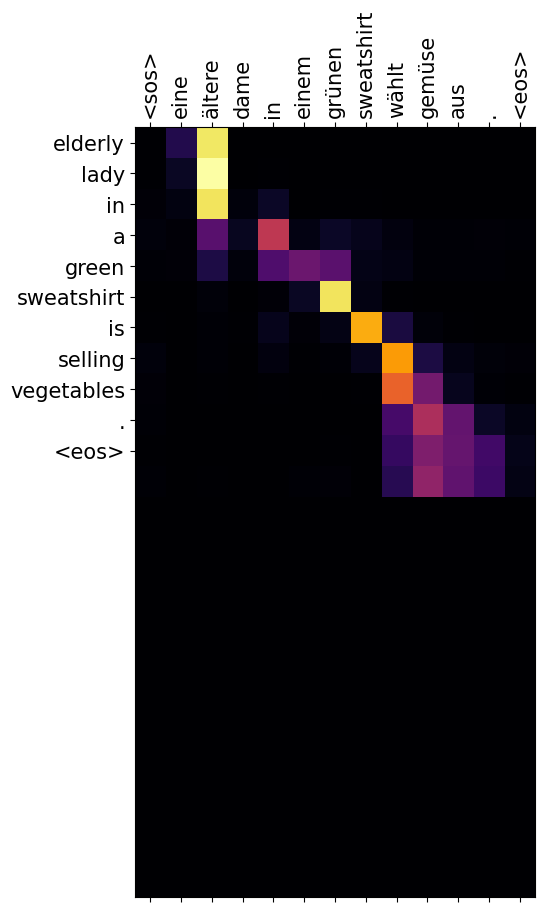

German sentence || "Eine ältere Dame in einem grünen Sweatshirt wählt Gemüse aus.
Reference Translation || An older lady in a green sweater picks out vegetables.
Predicted Translation || an elderly lady in a green sweatshirt is selling vegetables.



In [108]:
for _ in range(1):
    sample = random.randint(0,len(test_data['de']))
    de_tokens, en_tokens, attentions = translate_sentence_attention(
        sentence = test_data['de'][sample],
        model = model,
        en_nlp = en_nlp,
        de_nlp = de_nlp,
        en_vocab = en_vocab,
        de_vocab = de_vocab,
        lower = True,
        sos_token = '<sos>',
        eos_token = '<eos>',
        device = device,
        max_output_length=25)
    plot_attention(de_tokens, en_tokens, attentions)
    print(f'German sentence || "{test_data["de"][sample]}')
    print(f'Reference Translation || {test_data["en"][sample]}')
    prediction = ''
    for word in en_tokens:
        if word == '<eos>':
            break
        if word == '.':
            prediction = prediction[:-1] + word
        else:
            prediction += word + ' '
    print(f'Predicted Translation || {prediction}')
    print() 